In [61]:
import exoplanet

#exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [62]:
import csv
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import exoplanet as xo

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx 
from celerite2.theano import terms, GaussianProcess

This pipeline was adapted from the [Quick TESS](https://gallery.exoplanet.codes/tutorials/quick-tess/) case study from the exoplanet docs:

In [63]:
def pipeline(kepid, koi, period_guess, t0_guess, depth_guess, cadence = 'long'):
    
    nplanets = len(period_guess)
    
    lcfs = lk.search_lightcurve(kepid,
                                author="Kepler",
                                cadence=cadence).download_all(flux_column="pdcsap_flux")
    lc = lcfs.stitch().remove_nans().remove_outliers(sigma=7)

    x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
    y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
    yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

    texp = np.min(np.diff(x))
    
    fig,ax = plt.subplots(nrows= nplanets + 1, ncols = 1, figsize=(8,6*nplanets)) 

    ax[0].plot(x, y, "k", linewidth=0.5)
    ax[0].set_xlabel("Time [days]")
    _ = ax[0].set_ylabel("Relative flux [ppt]")
    ax[0].set_title(kepid)
    
    argsort_x = np.argsort(x)
    x = x[argsort_x]
    y = y[argsort_x]
    yerr = yerr[argsort_x]
    
    # Quick rotation period determination with Lomb-Scargle periodogram
    ls_results = xo.estimators.lomb_scargle_estimator(
        x, y, max_peaks=1, min_period=0.1, max_period=50.0, samples_per_peak=50)
    ls_peak = ls_results["peaks"][0]
    
    
    with pm.Model() as model:

        # Stellar parameters
        mean = pm.Normal("mean", mu=0.0, sigma=10.0) 
        u = xo.QuadLimbDark("u") #same, under Kipping 2013 comment
        star_params = [mean, u]

        # Gaussian process noise model
        sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
        log_sigma_gp = pm.Normal("log_sigma_gp", mu=0.0, sigma=10.0)
        log_rho_gp = pm.Normal("log_rho_gp", mu=np.log(10.0), sigma=10.0)
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
        )
        noise_params = [sigma, log_sigma_gp, log_rho_gp]

        # Planet parameters
        log_ror = pm.Normal(
            "log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0, shape = nplanets
        ) #changed
        ror = pm.Deterministic("ror", tt.exp(log_ror))

        # Orbital parameters
        log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0, shape = nplanets) #changed, eventually change into shape = n_planets 
        period = pm.Deterministic("period", tt.exp(log_period)) #same
        t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0, shape = nplanets) #changed
        log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0, shape = nplanets)
        dur = pm.Deterministic("dur", tt.exp(log_dur))
        b = xo.distributions.ImpactParameter("b", ror=ror, shape = nplanets) #changed

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b) #Same except this has duration

        # We're going to track the implied density for reasons that will become clear later
        pm.Deterministic("rho_circ", orbit.rho_star) #transit notebook uses light_curves

        # Set up the mean transit model
        star = xo.LimbDarkLightCurve(u)
        lc_model = mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=x, texp = texp), axis=-1)
            
        lc_models = mean + 1e3 * star.get_light_curve(orbit=orbit, r=ror, t=x, texp = texp)

        # Finally the GP observation model
        gp = GaussianProcess(kernel, t=x, diag=yerr ** 2 + sigma ** 2)
        gp.marginal("obs", observed=y - lc_model)

        # Double check that everything looks good - we shouldn't see any NaNs!
        print(model.check_test_point())

        # Optimize the model
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, [sigma])
        map_soln = pmx.optimize(map_soln, [ror, b, dur])
        map_soln = pmx.optimize(map_soln, noise_params)
        map_soln = pmx.optimize(map_soln, star_params)
        map_soln = pmx.optimize(map_soln)
        
        
        with model:

            lc_pred = pmx.eval_in_model(lc_models, map_soln)
            lc_sum  = pmx.eval_in_model(lc_model, map_soln)
            gp_pred = pmx.eval_in_model(gp.predict(y - lc_sum), map_soln)

            for i in range(nplanets):
                
                x_fold = (x - map_soln["t0"][i] + 0.5 * map_soln["period"][i]) % map_soln["period"][i] - 0.5 * map_soln["period"][i]
                inds = np.argsort(x_fold)
                
                flattened_lc = y - gp_pred - map_soln["mean"]
                #other = map_soln #not sure why I put this here
                sc = ax[i+1].scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3, rasterized = True)
                ax[i+1].plot(x_fold[inds], lc_pred[inds,i] - map_soln["mean"], "k")
                ax[i+1].set_xlabel("Time since transit [days]")
                ax[i+1].set_ylabel("Relative flux [ppt]")
                fig.colorbar(sc,label="Time [days]", ax = ax[i+1])
                _ = ax[i+1].set_xlim(-0.25, 0.25)
                ax[i+1].set_ylim(np.percentile(flattened_lc,0.01),np.percentile(flattened_lc,99.9))
                ax[i+1].set_title(koi[i])
                
                plt.tight_layout()     
                plt.savefig("./Figures/" + kepid.replace(" ","") + ".png", dpi = 200)
                plt.close()
            
            # Add KOI names to map_soln dictionary
            map_soln['koi'] = koi
            
            # Add signal-to-noise to map_soln dictionary
            resid = flattened_lc - lc_sum
            rms   = np.sqrt(np.median(resid ** 2))
            snr   = 1e3*(map_soln["ror"]**2)/rms
            
            map_soln["rms"] = rms
            map_soln["snr"] = snr
            
            # Add Lomb-Scargle period to map_soln dictionary
            map_soln["prot"] = ls_peak["period"]
            
            # Format map_soln values as arrays. This makes reading in the output files easier.
            for key in map_soln:
                map_soln[key] = np.array(map_soln[key])
            
            # Write map_soln dictionary to file (every key and value)
            w = csv.writer(open("./outputs/" + kepid.replace(" ","") + '.csv', "w"))
            for key, val in map_soln.items():
                w.writerow([key, val])
            
        
        return map_soln, x, y, yerr

# Read in sample file
This file has all of the pertinent information needed to provide initial estimates for the optimization step in the pipeline.

In [64]:
df = pd.read_csv('./sample.csv')
df.head() 

#To print columns do:
#for col in df.columns:
   #print(col)

,Unnamed: 0,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,...,b20_e_log10_iso_age,b18_KIC,b18_KOI,b18_Rp,b18_E_Rp,b18_e_Rp,b18_Fp,b18_E_Fp,b18_e_Fp,b18_Bin
0,6,10872983,K00756.03,Kepler-228 b,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,...,0.333468,10872983.0,K00756.03,1.874,0.510,0.217,863.776,104.338,91.555,0.0
1,10,5436502,K00834.04,Kepler-238 b,287.89713,0.0,19h11m35.31s,40.637821,0.0,+40d38m16.2s,...,0.102239,5436502.0,K00834.04,1.905,0.407,0.204,2500.588,231.349,207.679,0.0
2,20,8150320,K00904.01,Kepler-55 d,285.16833,0.0,19h00m40.40s,44.026459,0.0,+44d01m35.3s,...,0.493659,8150320.0,K00904.01,1.939,0.209,0.181,195.005,11.083,10.496,0.0
3,28,5880320,K01060.02,Kepler-758 c,293.08463,0.0,19h32m20.31s,41.135441,0.0,+41d08m07.6s,...,0.099703,5880320.0,K01060.02,1.836,0.365,0.121,1211.822,83.344,77.105,0.0
4,30,5880320,K01060.04,Kepler-758 e,293.08463,0.0,19h32m20.31s,41.135441,0.0,+41d08m07.6s,...,0.099703,5880320.0,K01060.04,1.879,0.262,0.220,588.402,40.468,37.439,0.0


In [65]:
import time
start_time = time.time()

kep_id = np.array(df.dr25_kepid)
unique_kepid = np.unique(df.dr25_kepid)
koi_name = np.array(df.dr25_kepoi_name)
koi_period = np.array(df.dr25_koi_period)
koi_depth = np.array(df.dr25_koi_depth)/10**3
koi_t0 = np.array(df.dr25_koi_time0bk)

def format_input(x):    
    return np.array([x]).reshape(-1)
    
failures = []

#for i in range(len(unique_kepid)):
for i in range(1):
    kic = unique_kepid[i]
    arg = kep_id == unique_kepid[i]
    _kepid = 'KIC' + str(kep_id[arg][0])
    _koi_name = format_input(koi_name[arg])
    _koi_period = format_input(koi_period[arg])
    _koi_depth = format_input(koi_depth[arg])
    _koi_t0 = format_input(koi_t0[arg])
    
    try:
        map_soln, x, y, yerr = pipeline(kepid = _kepid, koi = _koi_name, period_guess = _koi_period , t0_guess = _koi_t0, 
             depth_guess = _koi_depth, cadence = 'long')
        
    except:
        failures.append(_kepid) 
        print(i, _kepid)
        

#Write failures to file with date and time to keep track of runs
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d")

failures_df = pd.DataFrame({"kic": np.array(failures)})
failures_df.to_csv('./failures'+ dt_string + '.csv', index=False)

#Print total elapsed time
print((time.time() - start_time)/(3600), 'hours elapsed')

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_sigma_gp           -3.22
log_rho_gp             -3.22
log_ror                -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -29923.79
Name: Log-probability of test_point, dtype: float64


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
optimizi

message: Optimization terminated successfully.
logp: -29946.43198142642 -> -29896.26493617613
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot con

message: Desired error not necessarily achieved due to precision loss.
logp: -29896.264936176154 -> -29885.201269881367
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt

message: Desired error not necessarily achieved due to precision loss.
logp: -29885.201269881378 -> -29374.4811014973
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano

message: Optimization terminated successfully.
logp: -29374.4811014973 -> -29374.272026341252
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scal

message: Desired error not necessarily achieved due to precision loss.
logp: -29374.272026341256 -> -29374.25455860492
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (thean

0.006734257804022895 hours elapsed


array([ 131.5126894 ,  131.53312411,  131.55355871, ..., 1590.96063093,
       1590.98106548, 1591.00150022])

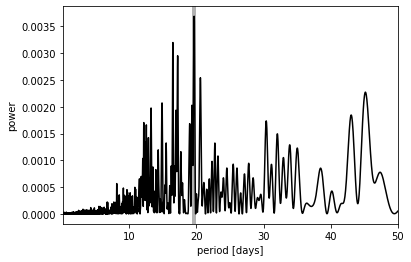

In [59]:


freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [60]:
peak['period']

19.655628659934415